## Two-pole or two-node study

Need:
pole.csv

In [499]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, atan2, pi, sqrt, atan, isnan

In [500]:
pole_excel_file = 'example_for_gridwere.xls'
df = pd.read_excel(pole_excel_file, sheet_name=None)
pole_mount_excel_file = 'pole_mount_data.xls'
df_mount = pd.read_excel(pole_mount_excel_file, sheet_name=None)

In [501]:
# creat a dictionary for pole mount data
df_mount_data = df_mount['pole mount data'].copy()
mount_data_dicts = {}
for mount_index in range(len(df_mount_data)):
    mount_data = df_mount_data.iloc[mount_index]
    if mount_data.loc['equipment_id'] not in mount_data_dicts.keys():
        mount_data_dict = {}
        for data_column in mount_data.index:
            if data_column != 'equipment_id':
                mount_data_dict[data_column] = mount_data.loc[data_column]
        mount_data_dicts[mount_data.loc['equipment_id']] = mount_data_dict
# print(mount_data_dicts)

In [515]:
# creat a dictionary for pole data
df_pole_data = df['pole data'].copy()
pole_data_dicts = {}
for pole_index in range(len(df_pole_data)):
    pole_data = df_pole_data.iloc[pole_index]
    if pole_data.loc['pole_id'] not in pole_data_dicts.keys():
        pole_data_dict = {}
        for data_column in pole_data.index:
            if data_column != 'pole_id':
                pole_data_dict[data_column] = pole_data.loc[data_column]
        pole_data_dicts[pole_data.loc['pole_id']] = pole_data_dict
# print(pole_data_dicts)

In [503]:
# creat a dictionary for pole connections
df_pole_section = df['pole section'].copy()
pole_section_dicts = {}
for section_index in range(len(df_pole_section)):
    pole_section = df_pole_section.iloc[section_index]
    if pole_section.loc['section_id'] not in pole_section_dicts.keys():
        pole_section_dict = {}
        for data_column in pole_section.index:
            if data_column != 'section_id':
                pole_section_dict[data_column] = pole_section.loc[data_column]
        pole_section_dicts[pole_section.loc['section_id']] = pole_section_dict
# print(pole_section_dicts)

In [504]:
df_pole_config = df['pole config'].copy()
pole_config_dicts = {}
for pole_config_index in range(len(df_pole_config)):
    pole_config = df_pole_config.iloc[pole_config_index]
    if pole_config.loc['config_id'] not in pole_config_dicts.keys():
        pole_config_dict = {}
        for data_column in pole_config.index:
            if data_column != 'config_id':
                pole_config_dict[data_column] = pole_config.loc[data_column]
        pole_config_dicts[pole_config.loc['config_id']] = pole_config_dict
# print(pole_config_dicts)

In [505]:
df_cable_config = df['cable config'].copy()
cable_config_dicts = {}
for cable_config_index in range(len(df_cable_config)):
    cable_config = df_cable_config.iloc[cable_config_index]
    if cable_config.loc['config_id'] not in cable_config_dicts.keys():
        cable_config_dict = {}
        for data_column in cable_config.index:
            if data_column != 'config_id':
                cable_config_dict[data_column] = cable_config.loc[data_column]
        cable_config_dicts[cable_config.loc['config_id']] = cable_config_dict
# print(cable_config_dicts)

In [506]:
df_weather_data = df['weather player'].copy()
time_stamps = []
wind_speeds = []
wind_directions = []
ambient_temps = []
wind_gusts = []
GHIs = []
default_wind_speed = 0
for weather_timesttamp in range(len(df_weather_data)):
    date = df_weather_data.iloc[weather_timesttamp]['time']
    if pd.isnull(date):
        raise Exception(f'column {weather_timesttamp}: time stamp is not set up')
    date = date - pd.Timestamp("1970-01-01")
    time_stamps.append(date.total_seconds())
    if pd.isnull(df_weather_data.iloc[weather_timesttamp]['wind_speed']) \
       or df_weather_data.iloc[weather_timesttamp]['wind_speed'] < 0:
        print(f'weather data does not include wind_speed at {date}, using local default_wind_speed')
        wind_speeds.append(0)
    else:
        wind_speeds.append(df_weather_data.iloc[weather_timesttamp]['wind_speed'])
    wind_directions.append(df_weather_data.iloc[weather_timesttamp]['wind_direction'])
    ambient_temps.append(df_weather_data.iloc[weather_timesttamp]['temperature'])
    wind_gusts.append(df_weather_data.iloc[weather_timesttamp]['wind_gusts'])
    GHIs.append(df_weather_data.iloc[weather_timesttamp]['global_horizontal_irradiance'])


## equation
<img src='moment_equations.png' width="400" height="400">

In [ ]:
def tilt_moment_cals(pole_height,pole_config_data['material_density'],top_diameter_ft,\
                                        ground_diameter_ft,tilt_angle,tile_direction)
                
                0.125*pole_config_data['material_density']*np.pi*pole_height*pole_height\
                                    *(((top_diameter_ft+ground_diameter_ft)**2)/6+top_diameter_ft*top_diameter_ft/3)\
                                    *sin(pi*pole_data['tilt_angle']/180)

In [519]:
def equipment_moment_cals(pole_key,wind_presure,wind_direction,guy_height,tilt_angle,tile_direction,mount_data,\
                          overload_factor_wind=1.75):
    # ingore the equipment weights for now
    equipment_moment_x = 0.0
    equipment_moment_y = 0.0
    equipment_moment_z = 0.0
    for equipment in mount_data.keys():
        if mount_data[equipment]['parent'] == pole_key:
            r_z = (mount_data[equipment]['equipment_height']-guy_height)*cos(pi*tilt_angle/180)
            r_x = (mount_data[equipment]['equipment_height']-guy_height)*cos(pi*tilt_angle/180)*cos(pi*tile_direction/180)
            r_y = (mount_data[equipment]['equipment_height']-guy_height)*cos(pi*tilt_angle/180)*sin(pi*tile_direction/180)
            wind_presure_x = wind_presure*cos(pi*wind_direction/180)
            wind_presure_y = wind_presure*sin(pi*wind_direction/180)
            equipment_size = mount_data[equipment]['mount_height']*mount_data[equipment]['equipment_diameter']/12
            equipment_moment_x += -r_z*wind_presure_y*equipment_size*overload_factor_wind
            equipment_moment_y += r_z*wind_presure_x*equipment_size*overload_factor_wind
            equipment_moment_z += (r_x*wind_presure_y-r_y*wind_presure_x)*equipment_size*overload_factor_wind
    return [equipment_moment_x,equipment_moment_y,equipment_moment_z]

In [526]:
def pole_moment_cals(pole_height,wind_presure,wind_direction,top_diameter_ft,ground_diameter_ft,tilt_angle,\
                     tile_direction,overload_factor_wind=1.75):
    r_z = pole_height*cos(pi*tilt_angle/180)/2
    r_x = pole_height*cos(pi*tilt_angle/180)*cos(pi*tile_direction/180)/2
    r_y = pole_height*cos(pi*tilt_angle/180)*sin(pi*tile_direction/180)/2
    pole_size = pole_height*pole_height*(2*top_diameter_ft+ground_diameter_ft)/6
    wind_presure_x = wind_presure*cos(pi*wind_direction/180)
    wind_presure_y = wind_presure*sin(pi*wind_direction/180)
    pole_moment_x = -r_z*wind_presure_y*pole_size*overload_factor_wind
    pole_moment_y = r_z*wind_presure_x*pole_size*overload_factor_wind
    pole_moment_z = (r_x*wind_presure_y-r_y*wind_presure_x)*pole_size*overload_factor_wind
    # print([pole_moment_x,pole_moment_y,pole_moment_z])
    return [pole_moment_x,pole_moment_y,pole_moment_z]

In [522]:
def norm_cals(x_list):
    norm_all = 0.0
    for x in x_list:
        norm_all += x*x
    return sqrt(norm_all)

In [521]:
def get_wind_span(pos1, pos2):
    # TODO, only use the distance to represent the wind span for now
    lat1 = pos1[0]*pi/180
    lat2 = pos2[0]*pi/180
    lon1 = pos1[1]*pi/180
    lon2 = pos2[1]*pi/180
    a = sin((lat2-lat1)/2)**2+cos(lat1)*cos(lat2)*sin((lon2-lon1)/2)**2
    return 6371e3*(2*atan2(np.sqrt(a),sqrt(1-a)))

In [516]:
feeder_file_path = '/Users/fxie2/Downloads/NG_to_Hitachi/Final List of Feeders.csv'
feeder_data = pd.read_csv(feeder_file_path)
# print(feeder_data)
summary = {}
count = 0
for index in range(len(feeder_data)):
    feeder_strings = feeder_data.iloc[index].tolist()[0].split('_')
    if str(feeder_strings[1]) not in summary.keys():
        summary[str(feeder_strings[1])] = 0
    summary[str(feeder_strings[1])] += 1
    count += 1
# print(count)
# print(summary)

In [537]:
def wire_moment_cals(pole_key,pole_height,wind_presure,wind_direction,pole_data,pole_section,pole_config,cable_config,ice_thickness):
    wire_moment_x = 0.0
    wire_moment_y = 0.0
    wire_moment_z = 0.0
    tension_moment_x = 0.0
    tension_moment_y = 0.0
    tension_moment_z = 0.0
    overload_factor_wire=1.65
    overload_factor_wind=1.75
    if pole_data[pole_key]['tilt_angle'] != 0:
        tilt_direction = pole_data[pole_key]['tilt_direction']
    else:
        tilt_direction = 0
    for section_id in pole_section.keys():
        if pole_section[section_id]['from'] == pole_key or pole_section[section_id]['to'] == pole_key:
            cable_type_id = pole_section[section_id]['cable_type']
            if cable_type_id in cable_config.keys():
                cable_diameter = cable_config[cable_type_id]['diameter']*39.3701 # 39.3701 account for m to inches conversion
            else:
                print(f'warning: cable type not reconginzed and default option is use')
                cable_diameter = cable_config['default']['diameter']*39.3701
            if pole_section[section_id]['from'] == pole_key:
                p0 = [pole_data[pole_section[section_id]['from']]['latitude'],pole_data[pole_section[section_id]['from']]['longitude']]
                p1 = [pole_data[pole_section[section_id]['to']]['latitude'],pole_data[pole_section[section_id]['to']]['longitude']]
                pole_cable_angle = pole_section[section_id]['from_pole_line_angle_z']
            else:
                p1 = [pole_data[pole_section[section_id]['from']]['latitude'],pole_data[pole_section[section_id]['from']]['longitude']]
                p0 = [pole_data[pole_section[section_id]['to']]['latitude'],pole_data[pole_section[section_id]['to']]['longitude']]
                pole_cable_angle = pole_section[section_id]['to_pole_line_angle_z']
            wind_span = get_wind_span(p0,p1) * 3.28084 # 3.28084 counts for m to ft conversion
            cable_height = pole_config['conductor_attach_height']
            section_heading = 180*atan2(p1[0]-p0[0],p1[1]-p0[1])/np.pi
            if wind_direction != None:
                angle_wind_section = wind_direction - section_heading
            else:
                angle_wind_section = 90
            cable_transverse_load_wind = wind_presure*sin(pi*abs(angle_wind_section)/180)*wind_span*(cable_diameter+2*ice_thickness)/12 
            try:
                cable_transverse_load_tension = pole_section[section_id]['tension'] * 0.2248 # 0.2248 account for N to lbs conversion
            except:
                print(f'tension is calculated with cable information and powerflow result')
                raise Exception(f'TODO: tension calculations')
                # TODO
            cable_wind_load = 3*cable_transverse_load_wind*overload_factor_wind # 3 counts for phases ABC
            tension_load = 3*cable_transverse_load_tension*overload_factor_wire
            # print(f'cable_load={cable_load}')
            r_z = pole_height*cos(pi*pole_data[pole_key]['tilt_angle']/180)
            r_x = pole_height*sin(pi*pole_data[pole_key]['tilt_angle']/180)*cos(pi*tilt_direction/180)
            r_y = pole_height*sin(pi*pole_data[pole_key]['tilt_angle']/180)*sin(pi*tilt_direction/180)
            # print(f'{pole_key}: lever arm are [{r_x},{r_y},{r_z}')
            cable_wind_load_z = -cable_wind_load*cos(pi*pole_cable_angle/180)
            cable_wind_load_x = cable_wind_load*sin(pi*pole_cable_angle/180)*cos(pi*section_heading/180)
            cable_wind_load_y = cable_wind_load*sin(pi*pole_cable_angle/180)*sin(pi*section_heading/180)
            tension_load_z = -tension_load*cos(pi*pole_cable_angle/180)
            tension_load_x = tension_load*sin(pi*pole_cable_angle/180)*cos(pi*section_heading/180)
            tension_load_y = tension_load*sin(pi*pole_cable_angle/180)*sin(pi*section_heading/180)
            # print(f'{pole_key}: cable load are [{cable_load_x},{cable_load_y},{cable_load_z}')
            wire_moment_x += r_y*cable_wind_load_z-r_z*cable_wind_load_y
            wire_moment_y += r_z*cable_wind_load_x-r_x*cable_wind_load_z
            wire_moment_z += r_x*cable_wind_load_y-r_y*cable_wind_load_x
            tension_moment_x += r_y*tension_load_z-r_z*tension_load_y
            tension_moment_y += r_z*tension_load_x-r_x*tension_load_z
            tension_moment_z += r_x*tension_load_y-r_y*tension_load_x
    # print(f'{pole_key}: wire moment are [{wire_moment_x},{wire_moment_y},{wire_moment_z}]')
    return [wire_moment_x,wire_moment_y,wire_moment_z],[tension_moment_x,tension_moment_y,tension_moment_z]

In [ ]:
def wind_pressure_failure_cals(resisting_moment,wire_moment_wind,tension_moment,pole_moment_wind,equipment_moment_wind,tilt_moment):
    
    pole_total_moment_x = wire_moment_wind[0]+tension_moment[0]+pole_moment_wind[0]+equipment_moment_wind[0]
    pole_total_moment_y = wire_moment_wind[0]+tension_moment[0]+pole_moment_wind[0]+equipment_moment_wind[0]
    pole_total_moment_z = wire_moment_wind[0]+tension_moment[0]+pole_moment_wind[0]+equipment_moment_wind[0]
    
    
    return wind_pressure_failure
    wind_pressure_failure = (resisting_moment - tension_moment_unit_wind) 
    / (pole_moment_unit_wind + equipment_moment_unit_wind + wire_moment_unit_wind)

-173.03229535755094
-0.0028403000000025713
188.03229535755094


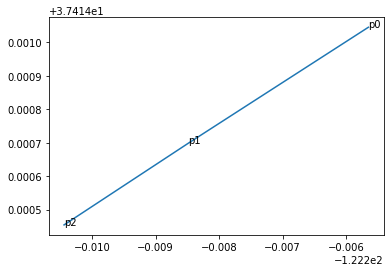

In [511]:
p0 = [37.41504514,-122.2056472]
p1 = [37.41469802,-122.2084875]
p2 = [37.41445409,-122.2104428]

p0_polt = [p0[1],p0[0]]
p1_polt = [p1[1],p1[0]]
section_heading = 180*atan2(p1[0]-p0[0],p1[1]-p0[1])/np.pi
print(section_heading)
print(p1[1]-p0[1])

wind_direction = 15
angle_wind_section = (wind_direction - section_heading)
print(angle_wind_section)
x = [p0[1],p1[1],p2[1]]
y = [p0[0],p1[0],p2[0]]
plt.text(x[0],y[0],'p0')
plt.text(x[1],y[1],'p1')
plt.text(x[2],y[2],'p2')
plt.plot(x,y)
plt.show()

In [538]:
pole_analysis_dict = {}
PS_OK = 1
PS_FAILED = 0
default_repair_time = 8
last_wind_speed = 0.0
for pole_key in pole_data_dicts.keys():
    pole_analysis_dict[pole_key] = {
        'wire_tention_on_pole' : [],
        'wind_moment_on_pole' : [],
        'total_moment_on_pole' : [],
        'pole_susceptibility' : [],
        'pole_stress' : [],
        'pole_status' : PS_OK,
        'pole_age' : [],
        'pole_current_hollow_diameter' : [],
        'critical_wind_speed' : 0.0,
        'pole_down_time' : 0.0,
        'pole_resisting_moment' : []
    }

# pole init
if len(pole_config_dicts.keys()) == 0:
    raise Exception(f'pole configuration is not set')

for pole_config_index in pole_config_dicts.keys():
    if np.isnan(pole_config_dicts[pole_config_index]['repair_time']) or pole_config_dicts[pole_config_index]['repair_time'] <= 0:
        print(f'{pole_config_index}: repair time should be position and default_repair_time will be used')
        pole_config_dicts[pole_config_index]['repair_time'] = default_repair_time

# pole precommit
# for timestamp_index in range(len(time_stamps)):
for timestamp_index in range(1):
    wind_speed = wind_speeds[timestamp_index]
    wind_direction = wind_directions[timestamp_index]
    for pole_key in pole_data_dicts.keys():
        pole_data = pole_data_dicts[pole_key]
        pole_config_id = pole_data['config']
        pole_config_data = pole_config_dicts[pole_config_id]
        t0 = time_stamps[timestamp_index]
        # effective pole height, for this example, unit in ft
        try:
            pole_height = pole_config_data['pole_length']-pole_config_data['pole_depth']\
                          -pole_data['guy_height']
        except:
            raise Exception(f'pole height error for {pole_key}')
        pole_t0_year = 1970 + int(t0/86400/365.24)
        age = pole_t0_year-pole_data_dicts[pole_key]['install_year']
        pole_analysis_dict[pole_key]['pole_age'].append(age)
        pole_ground_diameter = pole_config_data['ground_diameter'] - pole_height\
                               /(pole_config_data['pole_length']-pole_config_data['pole_depth'])\
                               *(pole_config_data['ground_diameter']-pole_config_data['top_diameter'])
        pole_top_diameter = pole_config_data['top_diameter']
        if age > 0 and pole_config_data['degradation_rate'] > 0:
            current_hollow_diameter = 2.0 * age * pole_config_data['degradation_rate'] * pole_ground_diameter
        else:
            current_hollow_diameter  = 0
        resisting_moment = 0.008186 * pole_config_data['strength_factor_250b_wood'] * pole_config_data['fiber_strength'] * (pole_ground_diameter**3 - current_hollow_diameter**3)
        if resisting_moment < 0:
            print('pole has degraded past point of static failure')
            resisting_moment = 0
        pole_analysis_dict[pole_key]['pole_resisting_moment'].append(resisting_moment)
        print(f'{pole_key}: resisting_moment = {resisting_moment} ft*lb at {time_stamps[timestamp_index]}')
        if (pole_analysis_dict[pole_key]['pole_status'] == PS_FAILED) and ((t0 - pole_analysis_dict[pole_key]['pole_down_time'])/3600.0 > pole_config_data['repair_time']):
            print('pole repair time has arrived')
            pole_analysis_dict[pole_key]['pole_status'] = PS_OK
            pole_analysis_dict[pole_key]['tilt_angle'] = 0.0 
            pole_analysis_dict[pole_key]['tilt_direction'] = 0.0
            pole_analysis_dict[pole_key]['install_year'] = 1970 + (t0/86400/365.24)
        elif pole_analysis_dict[pole_key]['pole_status'] == PS_OK and (last_wind_speed != wind_speed or pole_analysis_dict[pole_key]['critical_wind_speed'] == 0.0):
            top_diameter_ft = pole_top_diameter/12
            ground_diameter_ft = pole_ground_diameter/12
            tilt_angle = pole_data['tilt_angle']
            tile_direction = pole_data['tilt_direction']
            guy_height = pole_data['guy_height']
            
            if tilt_angle > 0.0:
                pole_moment_tilt = tilt_moment_cals(pole_height,pole_config_data['material_density'],top_diameter_ft,\
                                        ground_diameter_ft,tilt_angle,tile_direction)
                
                0.125*pole_config_data['material_density']*np.pi*pole_height*pole_height\
                                    *(((top_diameter_ft+ground_diameter_ft)**2)/6+top_diameter_ft*top_diameter_ft/3)\
                                    *sin(pi*pole_data['tilt_angle']/180)
                
                # print(f'{pole_key}: pole_moment_tilt = {pole_moment_tilt} ft*lb')
            else:
                pole_moment_tilt = 0.0
            
            wind_presure = 0.00256 * 2.24 * (wind_speed) * (wind_speed) # 2.24 account for m/s to mph conversion
            # print(f"wind_pressure = {wind_presure} psi")
            
            pole_moment_unit_wind = pole_moment_cals(pole_height,5.7344e-3,wind_direction,top_diameter_ft,ground_diameter_ft,tilt_angle,tile_direction)
            # print(f"{pole_key}: pole_moment_unit_wind = {norm_cals(pole_moment_unit_wind)} ft.lb.s/m")
            
            equipment_moment_unit_wind = equipment_moment_cals(pole_key,5.7344e-3,wind_direction,guy_height,tilt_angle,tile_direction,mount_data_dicts)
            # print(f"{pole_key}: equipment_moment_unit_wind = {norm_cals(equipment_moment_unit_wind)} ft.lb.s/m")
            
            wire_moment_unit_wind, tension_moment_unit_wind = wire_moment_cals(pole_key,pole_height,5.7344e-3,None,pole_data_dicts,pole_section_dicts,pole_config,cable_config_dicts,0)
            # print(f"{pole_key}: wire_moment_unit_wind = {norm_cals(wire_moment_unit_wind)} ft.lb.s/m")
            # print(f"{pole_key}: tension_moment_unit_wind = {norm_cals(tension_moment_unit_wind)} ft.lb.s/m")
            wind_pressure_failure = wind_pressure_failure_cals(resisting_moment,wire_moment_unit_wind,\
                                        tension_moment_unit_wind,pole_moment_unit_wind,\
                                        equipment_moment_unit_wind,wire_moment_unit_wind,wind_direction)
#             
            
            print(f'{pole_key}: wind_pressure_failure = {wind_pressure_failure} psi')
#             if wind_pressure_failure >= 0:
#                 critical_wind_speed = sqrt(wind_pressure_failure/(0.00256 * 2.24))
#                 print(f'{pole_key}: critical_wind_speed = {critical_wind_speed} m/s')
#             else:
#                 critical_wind_speed = 0
#                 print(f'{pole_key}: critical_wind_speed = {critical_wind_speed} m/s')
#             last_wind_speed = wind_speed
#             if wind_presure > 0:
#                 pole_moment_wind = pole_height*pole_height*(2*top_diameter_ft+ground_diameter_ft)/6*pole_config_data['overload_factor_transverse_general']


pole_1: resisting_moment = 10881.652412543199 ft*lb at 1623110400.0
pole_1: wire_moment_unit_wind = 113.64096617433957 ft.lb.s/m
pole_1: tension_moment_unit_wind = 776863.9556665377 ft.lb.s/m
pole_2: resisting_moment = 10881.652412543199 ft*lb at 1623110400.0
pole_2: wire_moment_unit_wind = 48.9409073866234 ft.lb.s/m
pole_2: tension_moment_unit_wind = 3768.6336283224555 ft.lb.s/m
pole_3: resisting_moment = 19302.67748743102 ft*lb at 1623110400.0
pole_3: wire_moment_unit_wind = 1.315955202003804 ft.lb.s/m
pole_3: tension_moment_unit_wind = 1802.4722158107074 ft.lb.s/m
pole_4: resisting_moment = 19302.67748743102 ft*lb at 1623110400.0
pole_4: wire_moment_unit_wind = 1.66875072797879 ft.lb.s/m
pole_4: tension_moment_unit_wind = 2756.544918395519 ft.lb.s/m
pole_5: resisting_moment = 10881.652412543199 ft*lb at 1623110400.0
pole_5: wire_moment_unit_wind = 8.382049370527866 ft.lb.s/m
pole_5: tension_moment_unit_wind = 4135.0766628001165 ft.lb.s/m
pole_6: resisting_moment = 19302.67748743102 